$$Two-sample\; hypotheis\; test$$<br>
$$X_1, \dots, X_n \in \mathbb R^d \overset{i.i.d.}{\sim} P_X,\;\;and \;\; Y_1,\dots, Y_n \in \mathbb R^d\overset{i.i.d.}{\sim} P_Y$$.
$$H_0: P_X= P_Y, \; and\; H_A: P_X\neq P_Y$$ 

For this notebook, we consider two multivariate Gaussian distributions, one is with 0 mean and identity covariance $P_X = \mathcal N(\mu_X, I_d)$, $\mu_X = 0_d$ and for the other distribution, we only vary the mean $P_y= \mathcal N(\mu_Y, I_d)$, $\mu_Y\in [-6, 6]$ and keep the covariance matrix same. Here  we compute the test statistics with 6 different two-sample testing procedures given below. Since, the goal is to generate soft out (plotting the test statistics), we expect that all $Test\; statistics \rightarrow 0$ as $\mu_X\rightarrow \mu_Y$. 

In [27]:
import numpy as np
import torch 
import ghalton
import ot
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import torch.nn.functional as F
from get_plan import plan
from sinkhorn_div import divergence
from sklearn.metrics.pairwise import euclidean_distances
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Rank Energy (RE) https://arxiv.org/pdf/1909.08733.pdf (Equation 4.4)
#### Soft Rank Energy (sRE) https://arxiv.org/pdf/2111.00043.pdf (Equation 15)
##### Energy distance https://pages.stat.wisc.edu/~wahba/stat860public/pdf4/Energy/EnergyDistance10.1002-wics.1375.pdf

In [28]:
def pairwiseDistance(Rx, Ry):
    '''calculating pairwise distance'''
    Rx_col = Rx.unsqueeze(1)
    Ry_lin = Ry.unsqueeze(0)
    M = torch.sqrt(torch.sum((Rx_col - Ry_lin)**2 , 2))
    return M
 
def testStatistics(Rx, Ry):
    '''
    RankEnergy(X, Y) = (2/mn)E||R(X)-R(Y)|| - (1/n^2) E||R(X)- R(X')|| - (1/m^2) E||R(Y)- R(Y')||
    '''
    n, m = Rx.shape[0], Ry.shape[0]
    assert n==m
    coefficient = n * m / (n + m)
    Rxx = pairwiseDistance(Rx + 1e-16, Rx) # to avoid 'divide by zero error'
    Ryy = pairwiseDistance(Ry + 1e-16 , Ry)
    Rxy = pairwiseDistance(Rx, Ry)
    rank_energy = coefficient * ( 2 * torch.mean(Rxy) - torch.mean(Rxx) - torch.mean(Ryy))
    return rank_energy

"""RANK ENERGY"""
def RankEenrgy(x, y):
    '''
        x: set of samples drwwn from P_X
        y: set of samples drawn from P_y
    '''
    assert x.shape == y.shape # ensuring they have the same shape
    n, d = x.shape
    concat_xy = np.concatenate((x, y), axis  = 0) # concat_xy has 2n samples
    sequencer = ghalton.Halton(d) 
    h = np.array(sequencer.get(2 * n)) # generating reference points
    a , b = ot.unif(2 * n), ot.unif(2 *n) # a, b: empirical weights
    M = ot.dist(concat_xy, h, metric ='sqeuclidean')
    M /= M.max() # normalizing the cost matrix 
    otPlan = ot.emd(a, b, M) # computing Optimal Transport plan 
    R = np.argmax(otPlan, axis = 1) # finding RANK indices corresponds to maximum values for each row
    Rx, Ry = torch.from_numpy(h[R[:n]]), torch.from_numpy(h[R[n:]]) # Rx: rank map corresponds to X_i's 
    RE = testStatistics (Rx, Ry) # computing energy distance between the corresponding ranks of X and Y 
    return RE.cpu().detach().numpy() 

"""SOFT RANK ENERGY"""
def SoftRankEenrgy(x, y, eps = 1):
    '''
        x: set of samples drwwn from P_X
        y: set of samples drawn from P_y
        eps: Entropic regularizer
    '''
    assert x.shape == y.shape #ensuring they have the same shape
    n, d = x.shape
    concat_xy = np.concatenate((x, y), axis  = 0) # concat_xy has 2n samples
    sequencer = ghalton.Halton(d)
    h = np.array(sequencer.get(2 * n))# generating reference points
    a , b = ot.unif(2 * n), ot.unif(2 *n)# a, b: empirical weights
    a, b = torch.from_numpy(a).to(device), torch.from_numpy(b).to(device)
    concat_xy = torch.from_numpy(concat_xy).to(device) 
    h = torch.from_numpy(h).to(device)# USING GPU FOR FASTER COMPUTATION
    entropicOtPlan = plan(a, concat_xy, b, h, p=2, eps = eps) # COMPUTING ENTROPIC OT PLAN
    row_sum = entropicOtPlan.sum(axis = 1) 
    scaled_plan = entropicOtPlan / row_sum[:, np.newaxis]
    R = torch.mm(scaled_plan, h) # COMPUTING ENTROPIC RANKS CORRESPONDING TO X AND Y
    sRE = testStatistics (R[:n], R[n:]) # COMPUTING SOFT RNAK ENERGY
    return sRE.cpu().detach().numpy()

#### Maximum mean discrepancy (MMD) https://jmlr.csail.mit.edu/papers/volume13/gretton12a/gretton12a.pdf
#### Please look at this paper to choose an appropriate kernel bandwidth https://arxiv.org/pdf/1406.2083.pdf. This paper talks about the decreasing power of kernel based test in high dimension. However, an appropriate choice of bandwidth may increase the test power

In [40]:
"""MAXIMUM MEAN DISCREPANCY"""
# TO COMPUTE MAXIMUMUM DISCREPANCY, WE USE GAUSSIAN KERNEL k(x,y) = exp((-\|x-y\|^2)/2\simga^2), WHERE \SIGMA IS THE 
# KERNEL BANDWIDTH, WHICH IS VERY IMPORANT TO TUNE FOR BETTER PERFORANCE.

def median_heuristic(X):
    '''Computing sigma using Median trick'''
    fullDat = np.append(cloud_i,cloud_j, axis=0)
    distance = ot.utils.dist(fullDat, fullDat, metric = 'sqeuclidean')
    med_sqdist = np.median(distance.flatten())
    return med_sqdist

def MaximumMeanDis(x, y, sigma = 1):
    '''
        Formual: MMD(X, Y) = - (2/mn)k(X,Y) - (1/n^2)k(X, X') - (1/m^2) K(Y, Y')
        x: set of samples drwwn from P_X
        y: set of samples drawn from P_y
        sigma: kernel bandwidth
    '''
    if sigma is None:
        sigma = median_heuristic(x)
    n, d = x.shape
    m, d2 = y.shape
    assert d == d2
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    k = torch.exp((-1/(2*sigma**2)) * dists**2) + torch.eye(n+m)*1e-5
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]
    mmd = k_x.sum() / (n * (n - 1)) + k_y.sum() / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)
    return mmd

## MMD with mixture Kernel
### https://arxiv.org/pdf/1502.02761.pdf (please look at section 4.3) 
### Bandwidth choice is very important as well

In [41]:
def MaximumMeanDis_mix(x, y, sigma_list, biased=True):
    '''
        x: set of samples drwwn from P_X
        y: set of samples drawn from P_y
        sigma_list: [1., 2,, 4, 8, 16]
    '''
    X = torch.from_numpy(x).to(device)
    Y = torch.from_numpy(y).to(device)
    mmd = mix_rbf_mmd2(X, Y, sigma_list = sigma_list, biased=True) # bias or unbiased, either way works
    return mmd
#     return torch.sqrt(F.relu(mmd)) # some papers also use the squared version of MMD   

def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    '''
        computing the kernel distance
    '''
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)
    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)
    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)
   
def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                      
        diag_Y = torch.diag(K_YY)                      
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             
    K_XY_sums_0 = K_XY.sum(dim=0)                     

    Kt_XX_sum = Kt_XX_sums.sum()                       
    Kt_YY_sum = Kt_YY_sums.sum()                       
    K_XY_sum = K_XY_sums_0.sum()                       

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2

####  Wasserstein-1 distance  https://www.mdpi.com/1099-4300/19/2/47 (Equation 1 with p=1)
####  Wassertein-Quantile distance https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9246231 (Equation 12)
####  Sinkhorn divergence https://hal.science/hal-01647869/ (Equation 2.5)

In [42]:

"""WASSERSTEIN-1 DISTANCE"""
def Wasserstein_1(x, y):
    #https://pythonot.github.io/quickstart.html#computing-wasserstein-distance
    assert x.shape == y.shape
    n, d = x.shape
    a, b = ot.unif(n), ot.unif(n)
    M = ot.dist(x, y, metric = 'euclidean')
    W1 = ot.emd2(a, b, M)
    return W1

"""WASSERSTEIN-QUANTILE DISTANCE"""
"""a distribution-free version of Wasserstein distance"""
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9246231
def F_GInv(F,G):
    F=F.flatten()
    G=G.flatten()
    n = len(F)
    m = len(G)
    Fsort = np.sort(F)
    Gsort = np.sort(G)
    outX = np.zeros(m)
    outY = np.zeros(m)
    for i in range(m):
        dist = np.argwhere(Fsort <= Gsort[i])
        outY[i] = len(dist)/n
        outX[i] = (i+1)/m # cdf jumps at points in Gm
    return (outX, outY)

def DistanceToUniform(p, cdf):
    #This only computes distance, we need squared distance. 
    # we assume that [0,0], and [1,1] are not included
    p=np.append(p,1)
    cdf = np.append(cdf,1)
    prevX = 0
    prevY = 0
    total = 0
    overUnder = 0

    for i in range(len(p)):
        if (cdf[i] < p[i]): # we are under
            if overUnder == 1: # we were over
                total += (np.abs(prevX-prevY) + (p[i]-prevY))/2 * (p[i]-prevX) # trapezoid
            elif overUnder !=-1: # we stayed under
                total += (np.abs(prevX-prevY) + (cdf[i]-prevY))/2 *(p[i]-prevX)
            overUnder = 1
        elif (cdf[i] < p[i]): # we are over
            if overUnder == -1: # and now we are under
                total += (np.abs(prevX-prevY) + 0)/2 * (prevY - prevX)
                total += (0 + (p[i]-cdf[i]))/2 * (p[i] - prevY)
            elif overUnder !=-1: # we are still over
                # we need to check if we fell under for some part
                if (p[i] < prevY): # if we did we have to integrate 2 smaller triangles
                    total += (np.abs(prevX-prevY))/2 * (prevY-prevX)
                    total += (p[i]-prevY)/2 * (p[i]-prevY)
                else:
                    total += (np.abs(prevY-prevX)+(cdf[i] - p[i]))/2 * (p[i]-prevX)
            overUnder = 0
        else:
            total+= np.abs(prevY-prevX)/2*(p[i]-prevX)
        
        prevX=p[i]
        prevY = cdf[i]
    return total

def DistanceSquaredToUniform(pp,cdf,step= 0.01):
    pp=np.append(pp,1)
    cdf = np.append(cdf,1)
    xAll = np.linspace(0,1,int(1/step)+1)
    total = 0 
    for x in xAll:
        argX = np.argwhere(pp>=x)
        total += (x - cdf[argX[0]])*(x - cdf[argX[0]])*step
    return total

def TwoSampleWTest(x, y, step = None):
    lenA = len(x)
    lenB = len(y)
    (cdfX, cdfY) = F_GInv(x,y)
            
    if (step is None):
        distOut = DistanceSquaredToUniform(cdfX, cdfY)*(lenA*lenB)/(lenA+lenB)
    else:
        distOut = DistanceSquaredToUniform(cdfX, cdfY, step=step)*(lenA*lenB)/(lenA+lenB)
    return distOut

"""SINKHORN DIVERGENCE"""
def two_sample_sinkdiv(x, y, eps = 1):
    sinkdiv =divergence(x, y, eps)
    return sinkdiv

In [43]:
n = 200
d = 10
mu_x, cov_x, = np.zeros(d),  np.eye(d)
X= mvn.rvs(mu_x, cov_x, n) # sampling X
sigma = 1 # is a hyperparameter. need to tuned for better performance
sigma_list= [1, 2, 4, 8, 16, 32] # is a hyperparameter. need to tuned for better performance

In [47]:
mu_y_List = np.arange(-6, 7, 1)
RE_list, sRE_list, mmd_list, W1_list, WQT_list, sinkdiv_list = list(), list(), list(), list(),list(),list()
for index in mu_y_List:
    mu_y = index * np.ones(d)
    cov_y = cov_x
    Y = mvn.rvs(mu_y, cov_y, n)
    RE_list.append(RankEenrgy(X, Y))
    sRE_list.append(SoftRankEenrgy(X, Y, eps = 1))
    sinkdiv_list.append(two_sample_sinkdiv(X, Y, eps = 1))
#     mmd_list.append(MaximumMeanDis(X, Y, sigma = sigma)) # single kernel
    mmd_list.append(MaximumMeanDis_mix(X, Y, sigma_list = sigma_list)) # mixed kernel
    W1_list.append(Wasserstein_1(X, Y))
    WQT_list.append(TwoSampleWTest(X, Y))

Text(0, 0.5, 'Wasserstein-Quantile distance')

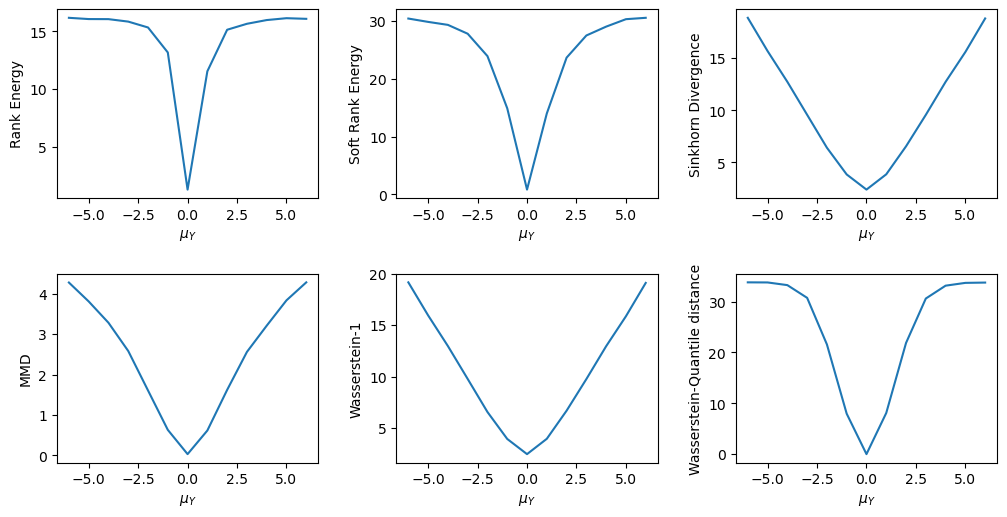

In [48]:
fig, ax = plt.subplots(2, 3, figsize = (10, 5))
plt.subplots_adjust(top=0.92, bottom=0.013, left=0.04, right=0.98, hspace=.4, wspace=.3)
ax[0, 0].plot(mu_y_List, RE_list)
ax[0, 0].set_xlabel('$\mu_Y$')
ax[0, 0].set_ylabel('Rank Energy')

ax[0, 1].plot(mu_y_List, sRE_list)
ax[0, 1].set_xlabel('$\mu_Y$')
ax[0, 1].set_ylabel('Soft Rank Energy')

ax[0, 2].plot(mu_y_List, sinkdiv_list)
ax[0, 2].set_xlabel('$\mu_Y$')
ax[0, 2].set_ylabel('Sinkhorn Divergence')

ax[1, 0].plot(mu_y_List, mmd_list)
ax[1, 0].set_xlabel('$\mu_Y$')
ax[1, 0].set_ylabel('MMD')

ax[1, 1].plot(mu_y_List, W1_list)
ax[1, 1].set_xlabel('$\mu_Y$')
ax[1, 1].set_ylabel('Wasserstein-1')

ax[1, 2].plot(mu_y_List, WQT_list)
ax[1, 2].set_xlabel('$\mu_Y$')
ax[1, 2].set_ylabel('Wasserstein-Quantile distance')